<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/330_beta_binomial.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(post-inference-prediction-notebook)=
# Inferenza e predizione a posteriori

L'obiettivo di questo capitolo è esaminare in dettaglio il processo di lavoro all'interno del contesto dell'inferenza bayesiana una volta ottenuta la stima della distribuzione a posteriori. A titolo esemplificativo, utilizzeremo il dataset denominato "moma_sample", il quale rappresenta un campione casuale di 100 artisti provenienti dal Museo di Arte Moderna di New York (MoMA) e contiene diverse informazioni relative a ciascun artista.

Il nostro interesse è focalizzato sulla determinazione della probabilità che un artista presente nel MoMA appartenga alla generazione X o a una generazione successiva (nati dopo il 1965). Questa probabilità sarà indicata come $\pi$.

Iniziamo a importare i pacchetti necessari.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

Importiamo i dati.

In [3]:
moma_sample = pd.read_csv("../data/moma_sample.csv")

Esaminiamo le prime cinque righe del DataFrame.

In [44]:
moma_sample.head()

,artist,country,birth,death,alive,genx,gender,count,year_acquired_min,year_acquired_max
0,Ad Gerritsen,dutch,1940,2015.0,False,False,male,1,1981,1981
1,Kirstine Roepstorff,danish,1972,NaN,True,True,female,3,2005,2005
2,Lisa Baumgardner,american,1958,2015.0,False,False,female,2,2016,2016
3,David Bates,american,1952,NaN,True,False,male,1,2001,2001
4,Simon Levy,american,1946,NaN,True,False,male,1,2012,2012


Utilizzeremo una distribuzione a priori $\operatorname{Beta}(4, 6)$ poco specifica per il parametro $\pi$, e affermeremo che è probabile che la probabilità sia inferiore a 0.5, anche se non siamo particolarmente sicuri sul suo esatto valore.

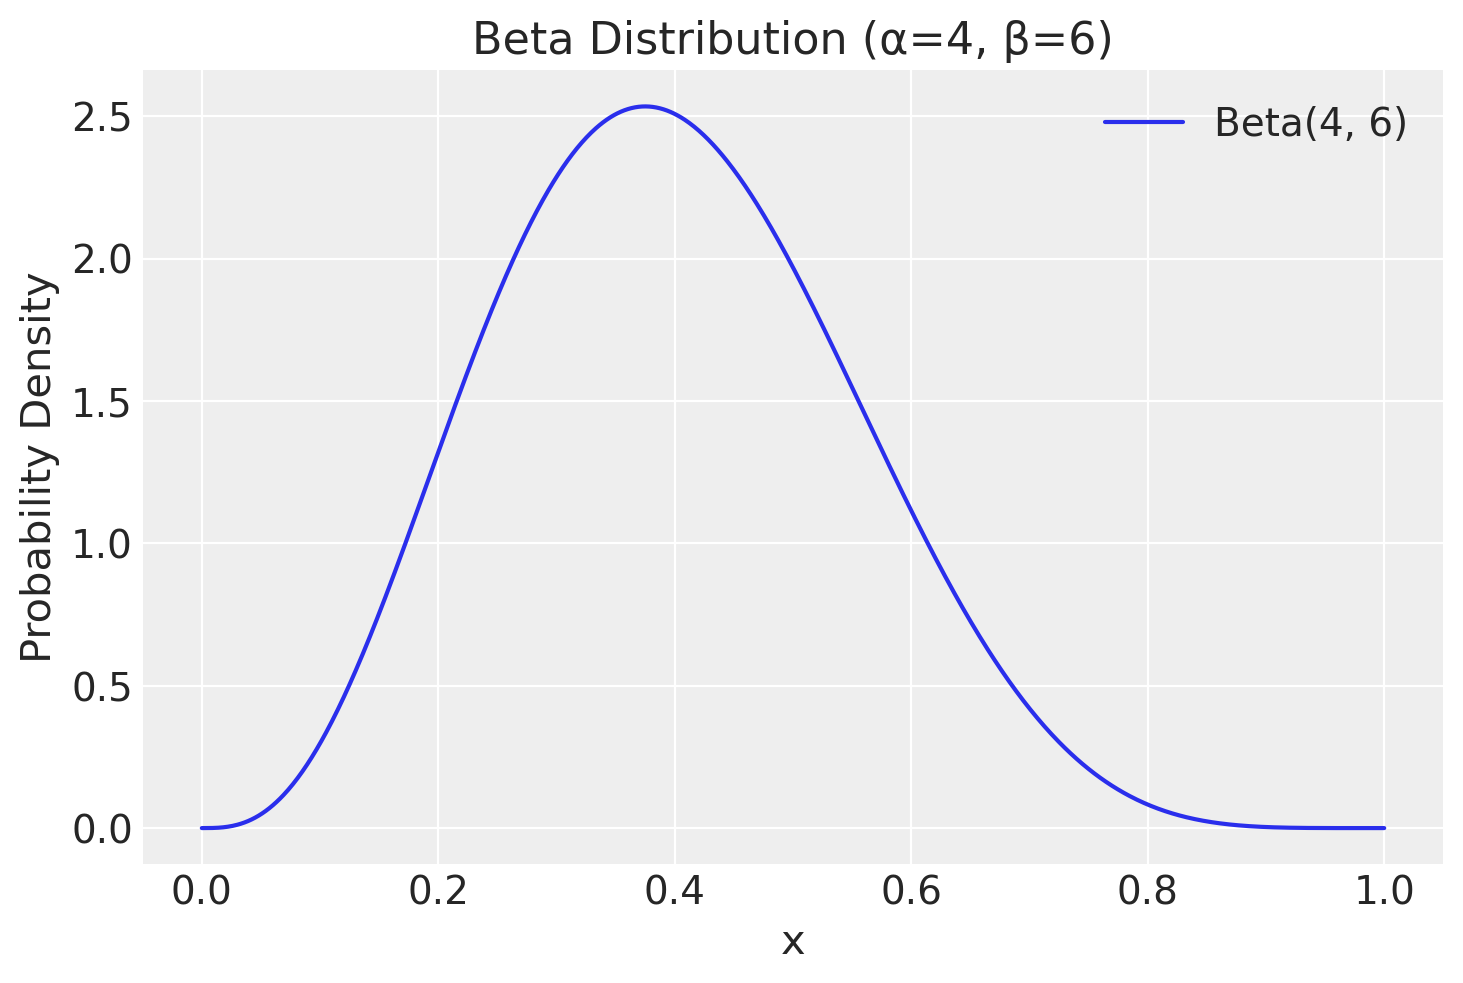

In [4]:
# Parameters of the Beta distribution
alpha = 4
beta = 6

# Generate x values
x = np.linspace(0, 1, 1000)

# Calculate the corresponding y values from the Beta distribution
y = stats.beta.pdf(x, alpha, beta)

# Create the plot
plt.plot(x, y, label=f'Beta({alpha}, {beta})')
plt.title(f'Beta Distribution (α={alpha}, β={beta})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

Dai dati osserviamo che solo 14 artisti su 100 appartengono alla generazione X o a una generazione successiva.

In [5]:
result = moma_sample["genx"].value_counts()
print(result)

genx
False    86
True     14
Name: count, dtype: int64


Il valore campionario $y$ = 14 rappresenta le proprietà del campione osservato. Tuttavia, dato che il MOMA ospita opere di migliaia di artisti, permane la domanda riguardo al valore reale di $\theta$ in questa popolazione.

Attraverso le proprietà delle famiglie coniugate, possiamo calcolare la distribuzione a posteriori esatta:

```python
Y ~ Binomiale(100, π)
π = Beta(4, 6)
```

Dato che abbiamo osservato $Y = 14$, la distribuzione a posteriori esatta effettiva è:

```python
π | (Y = 14) ~ Beta(4 + 14, 6 + 100 - 14) → Beta(18, 92)
```

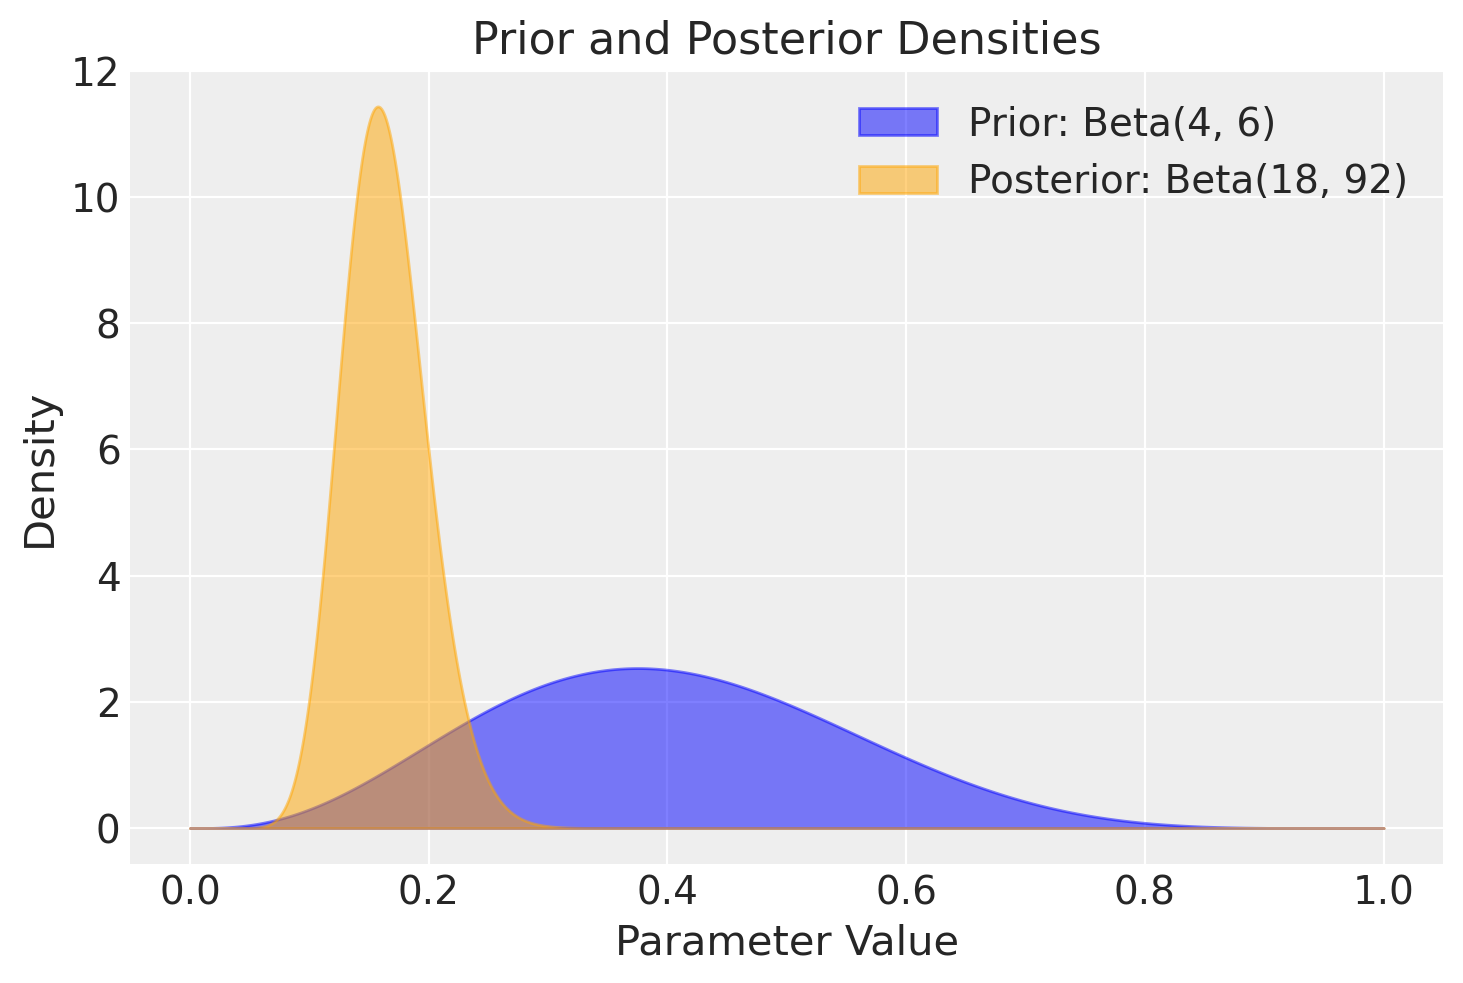

In [6]:
x = np.linspace(0, 1, 1000)

prior_density = stats.beta.pdf(x, 4, 6)
posterior_density = stats.beta.pdf(x, 18, 92)

plt.fill_between(x, prior_density, alpha=0.5, color='blue', label='Prior: Beta(4, 6)')
plt.fill_between(x, posterior_density, alpha=0.5, color='orange', label='Posterior: Beta(18, 92)')
plt.legend()
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.title('Prior and Posterior Densities')
plt.show()

Ora che abbiamo ottenuto la distribuzione a posteriori, possiamo effettuare varie operazioni con essa:

- Stima
- Test di ipotesi
- Predizione

Ma prima, a scopo illustrativo, mostriamo come ottenere un'approssimazione della distribuzione a posteriori mediante MCMC:

In [7]:
y = 14
ntrials = 100

alpha_prior = 4
beta_prior = 6

In [8]:
bb_model = pm.Model()

with bb_model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

In [9]:
with bb_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


La figura seguente rappresenta la distribuzione a posteriori di $\theta$ ottenuta mediante il metodo MCMC.

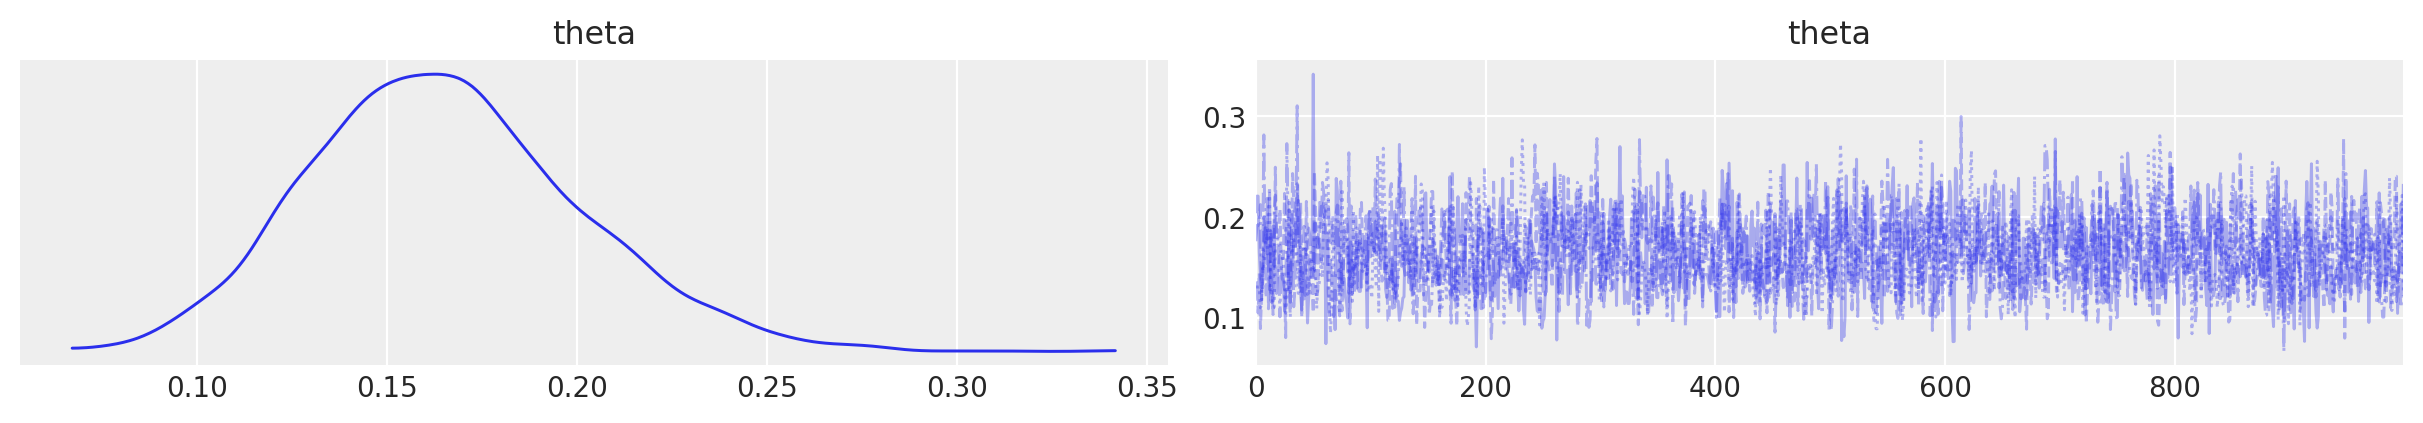

In [10]:
az.plot_trace(idata, combined=True);

La figura seguente mostra insieme la distribuzione a priori e quella a posteriori.

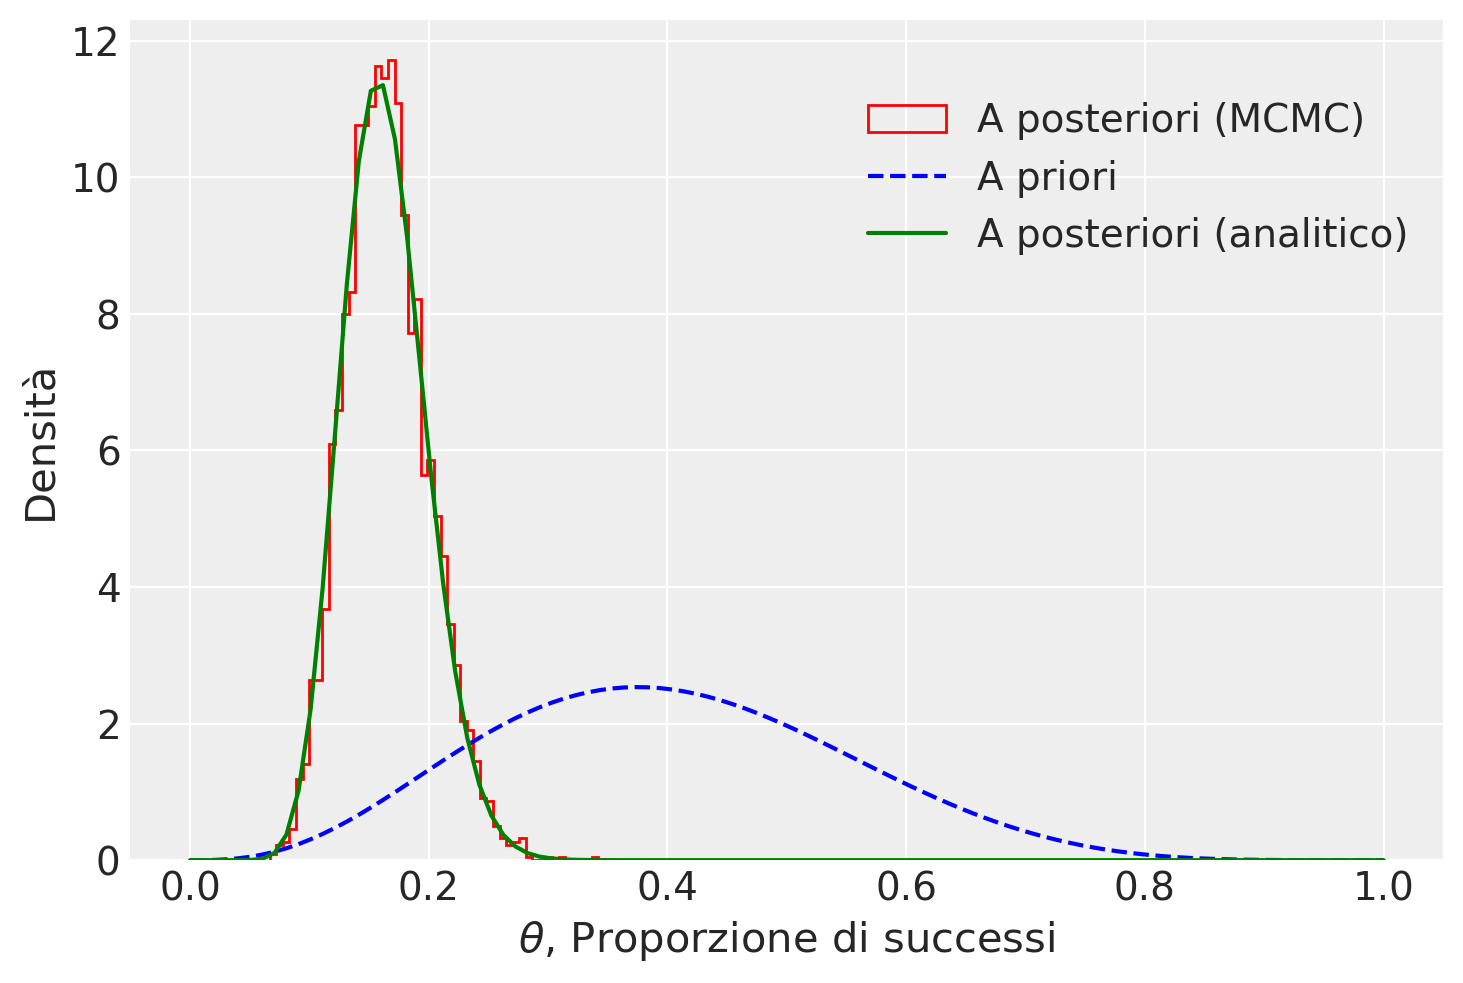

In [11]:
post = az.extract(idata)
p_post = post["theta"]

# Posterior: Beta(alpha + y, beta + n - y)
alpha_post = alpha_prior + y
beta_post = beta_prior + ntrials - y

plt.hist(
    p_post,
    bins=50,
    histtype="step",
    density=True,
    label="A posteriori (MCMC)",
    color="red",
)

# Plot the analytic prior and posterior beta distributions
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha_prior, beta_prior), "--", label="A priori", color="blue")
plt.plot(
    x,
    stats.beta.pdf(x, alpha_post, beta_post),
    label="A posteriori (analitico)",
    color="green",
)

# Update the graph labels
plt.legend(title=" ", loc="best")
plt.xlabel("$\\theta$, Proporzione di successi")
plt.ylabel("Densità");

## Stima 

Un sommario della distribuzione a posteriori si ottiene con il metodo `az.summary()`.

In [58]:
az.summary(idata, hdi_prob=0.94, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.034,0.103,0.23,0.001,0.001,1685.03,2790.468,1.001


Si ottiene così l'intervallo di credibilità a più alta densità a posteriori (HPD) al 94%. Questo intervallo ci informa sul fatto che, a posteriori, possiamo essere certi al 94%, che il vero valore del parametro $\theta$ sia contenuto nell'intervallo [0.103, 0.23].

## Test di ipotesi

Supponiamo di essere interessati alle due seguenti ipotesi:

$$
\begin{split}
H_0: & \; \; \pi \ge 0.2 \\
H_a: & \; \; \pi < 0.2
\end{split}
$$

La nostra domanda è la seguente: Date le nostre credenze iniziali e i dati disponibili, quale importanza relativa possiamo attribuire a queste due ipotesi?

Per affrontare questa questione, il primo passo consiste nel ricavare i campioni dalla distribuzione a posteriori di $\theta$ che sono stati ottenuti tramite il campionamento MCMC.

Iniziamo esaminando l'oggetto `idata`, che contiene le informazioni rilevanti sulla distribuzione a posteriori ottenuta dal campionamento MCMC.

In [32]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Possiamo estrarre i valori di interesse mediante la sintassi seguente. Otteniamo così un array 4 $\times$ 1000 -- il default è di quattro catene, con 2000 iterazioni ciascuna, di cui 1000 di burn-in.

In [16]:
theta_post = idata.posterior["theta"]
theta_post.shape

(4, 1000)

La stima a posteriori di $\theta$ è data dalla media di questi 4000 valori.

In [17]:
print(np.mean(theta_post < 0.2))

<xarray.DataArray 'theta' ()>
array(0.83875)


Possiamo dunque calcolare gli odds a posteriori:

In [18]:
post_odds = (np.mean(theta_post < 0.2)) / (1 - np.mean(theta_post < 0.2))
print(post_odds)

<xarray.DataArray 'theta' ()>
array(5.20155039)


Ciò implica che la probabilità che $\pi$ sia inferiore al 20% è circa 6 volte superiore rispetto alla probabilità che sia al di sopra del 20%.

Tuttavia, tutto ciò si basa sulla distribuzione a posteriori. Prima di avere osservato i dati del campione, avevamo una distribuzione a priori $\operatorname{Beta}(6, 4)$, e in quel contesto avevamo una probabilità del 9% che $H_0$ fosse vera e una probabilità del 91% che fosse falsa.

In [19]:
threshold = 0.2
prior_prob = stats.beta.cdf(threshold, a=alpha_prior, b=beta_prior)

In [20]:
prior_odds = prior_prob / (1 - prior_prob)
print(prior_odds)

0.09366320688790145


Possiamo combinare le informazioni degli odds a posteriori e degli odds a priori in una quantità chiamata Bayes Factor, che è semplicemente il rapporto tra le due:

In [21]:
BF = post_odds / prior_odds
print(BF)

<xarray.DataArray 'theta' ()>
array(55.53461771)


Dopo aver appreso informazioni riguardo a 14 artisti appartenenti alla generazione X, le probabilità posteriori della nostra ipotesi $H_a: \; \pi < 0.2$ sono circa 60 volte superiori rispetto alle probabilità a priori.

Questo è un esempio di test di ipotesi bayesiano.

## Predizioni

Affrontiamo ora la questione di come utilizzare i valori ottenuti dalla catena di Markov per approssimare il modello predittivo a posteriori della variabile casuale $\tilde{Y}$ che rappresenta il numero di artisti che appartengono alla generazione X o a una generazione ancor più giovane.  Immaginiamo di disporre di un nuovo campione composto da 20 artisti provenienti dal MOMA. L'obiettivo è quello di formulare previsioni sulla distribuzione dei possibili valori di $Y$ in questo nuovo campione.  Il modello predittivo a posteriori riflette due fonti di variabilità:

- la prima fonte di variabilità riguarda la varianza della distribuzione binomiale $\tilde{Y} \mid \pi \sim \text{Binomiale}(20, \pi)$;
- la seconda fonte di variabilità riguarda l'incertezza su $\pi$ che è espressa dalla distribuzione a posteriori di questo parametro.

Per considerare entrambe le fonti di variabilità nelle previsioni a posteriori di $\tilde{Y}$, possiamo impiegare `np.random.binomial` per simulare un singolo risultato $\tilde{Y}$ dalla distribuzione binomiale (20, π) per ciascuno dei 4000 valori nella catena di Markov relativa a π.

A tale scopo, utilizzeremo l'array `theta_post` (di dimensioni 4 $\times$ 1000) che abbiamo creato in precedenza. Le informazioni che ci servono sono elencate di seguito.

In [22]:
num_chains = 4
num_iterations = 1000
n_trials = 20

Il codice seguente genera un vettore di 4000 valori $\tilde{Y}$.

In [23]:
# Initialize an array to store the generated y values
generated_y_values = np.empty((num_chains, num_iterations))

# Loop through each chain and iteration
for chain in range(num_chains):
    for iteration in range(num_iterations):
        theta = theta_post[chain, iteration]
        y = stats.binom.rvs(n=n_trials, p=theta)
        generated_y_values[chain, iteration] = y

# Reshape the array to a 1D vector
generated_y_vector = generated_y_values.reshape(-1)

generated_y_vector.shape

(4000,)

In [92]:
generated_y_vector

array([7., 4., 6., ..., 4., 2., 1.])

Possiamo ora usare ArviZ per rappresentare graficamente la distribuzione predittiva a posteriori di $\tilde{Y}$ nel caso di un nuovo campione di ampiezza 20. Scegliamo un intervallo di credibilità di 0.8.

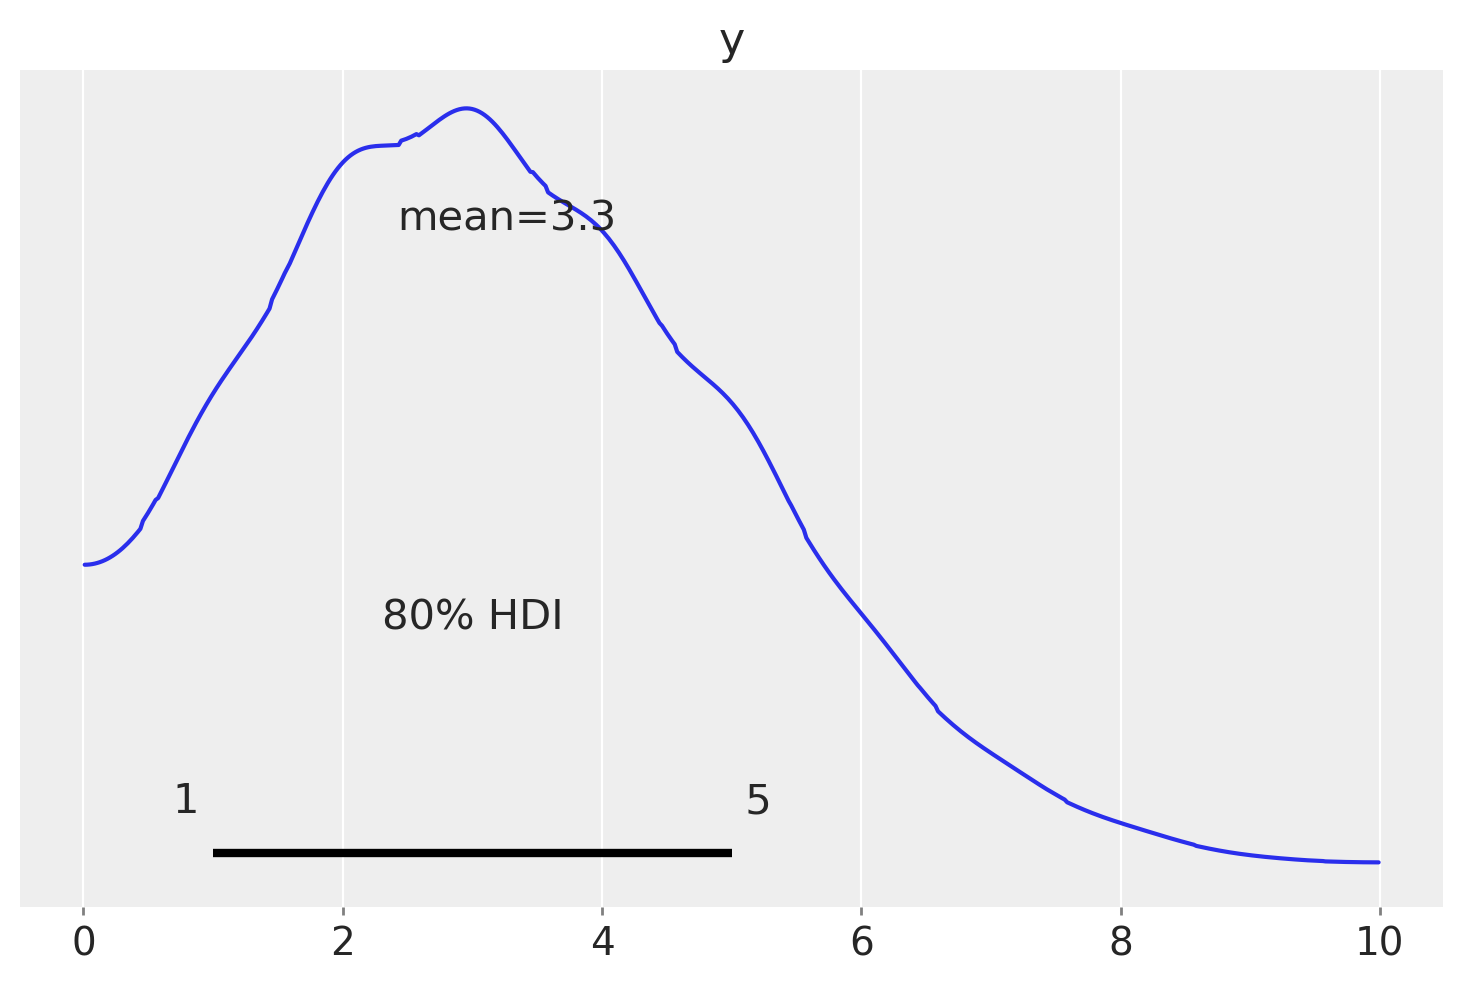

In [24]:
# Create a dictionary with the data
data_dict = {"y": generated_y_vector}

# Create the plot using ArviZ
az.plot_posterior(data_dict, hdi_prob=0.8, kind="kde", bw=0.5);

Possiamo concludere affermando che, nel caso in cui analizzassimo un nuovo campione di 20 artisti provenienti dal MOMA, ci potremmo attendere che solamente 3 di questi artisti facciano parte della generazione X o di una generazione successiva. Tuttavia, è importante sottolineare che questa stima è soggetta a un certo grado di incertezza. Considerando un livello di fiducia soggettivo dell'80%, l'intervallo di variabilità stimato va da un minimo di 1 ad un massimo di 5 artisti, che potrebbero essere rappresentativi di queste generazioni successive. 

Tutto questo processo può essere automatizzato, usando PyMC, ma solo se consideriamo un campione futuro avente la stessa ampiezza del campione presente ($n$ = 100). Le istruzioni necessarie sono indicate di seguito.

In [27]:
with bb_model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


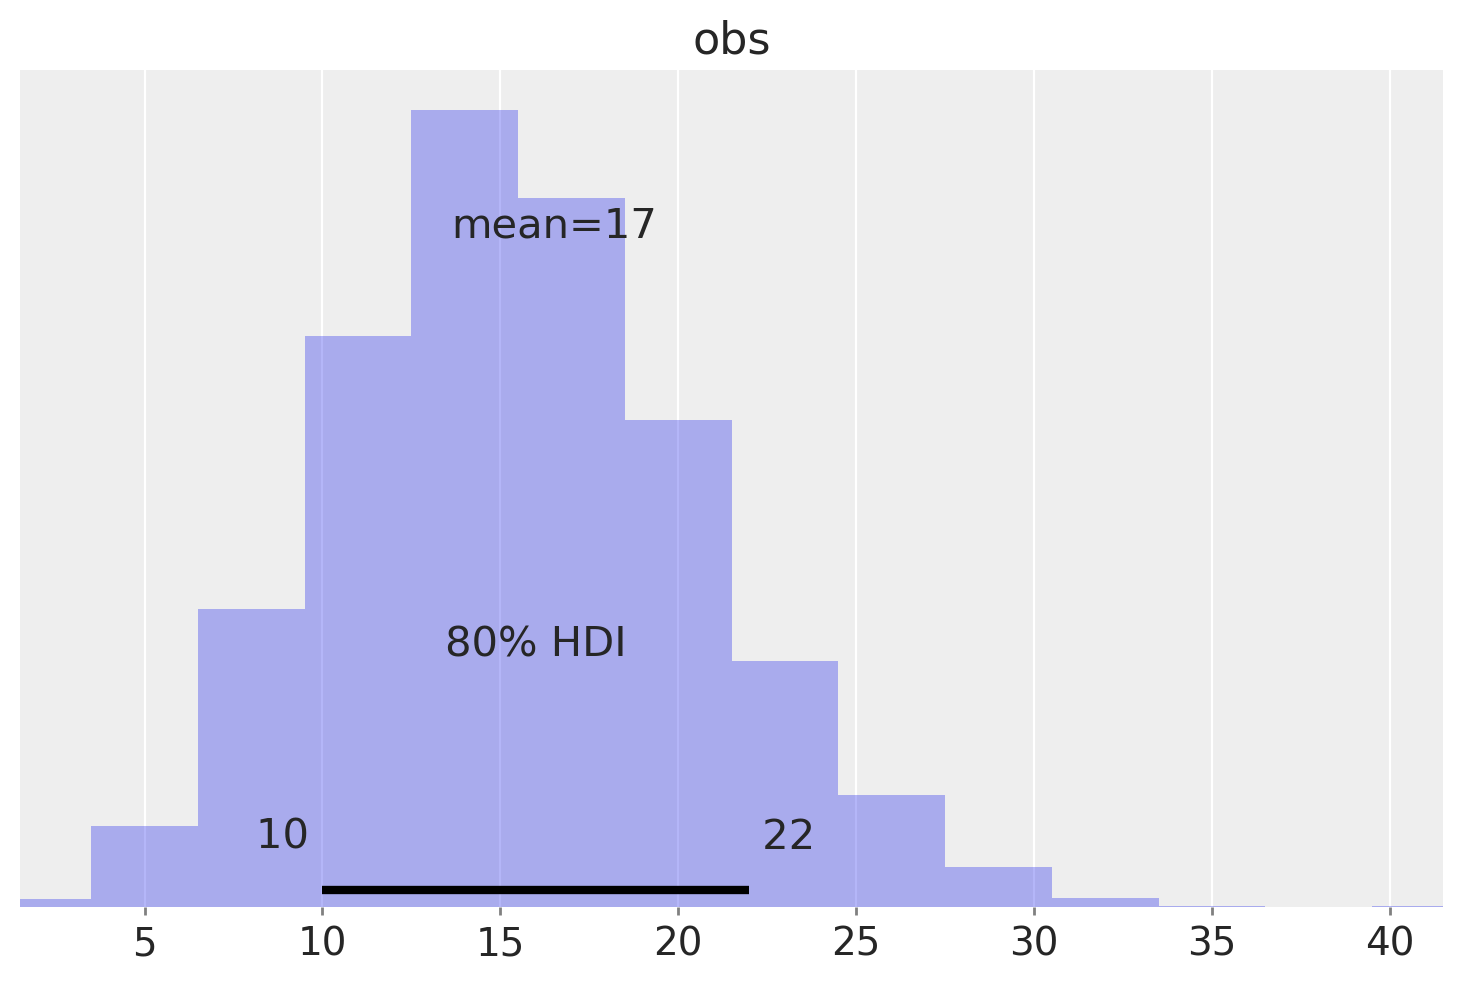

In [28]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.80);

Considerando un futuro campione costituito da 100 osservazioni, possiamo fare una previsione in cui ci aspettiamo che circa 16 artisti facciano parte della generazione X o di generazioni successive. Questa stima è accompagnata da un intervallo di credibilità all'80% che varia da un minimo di 9 ad un massimo di 21 artisti.

## Commenti e considerazioni finali 

Nel presente capitolo sono state illustrate le metodologie per la trasformazione della distribuzione a posteriori. Sono state esaminate le modalità attraverso le quali è possibile derivare un intervallo di credibilità. Questo intervallo individua una regione in cui si collocano i plausibili valori a posteriori di π, offrendo così un'analisi sia dei valori tipicamente manifesti a posteriori sia dell'entità dell'incertezza legata a π. Successivamente, è stata affrontata la verifica delle ipotesi a posteriori. Questa metodologia consente di valutare in modo relativo due ipotesi contrastanti riguardo a π. Infine, è stata discussa la previsione a posteriori, che considera congiuntamente sia la variabilità introdotta dal processo di campionamento di $\tilde{Y}$ sia la variabilità a posteriori di π.


## Watermark

In [30]:
%watermark -n -u -v -iv -w

Last updated: Sat Jul 15 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.12.0

seaborn   : 0.12.2
pymc      : 5.6.1
pandas    : 1.5.3
scipy     : 1.10.1
arviz     : 0.16.0
matplotlib: 3.7.1
numpy     : 1.25.0

Watermark: 2.4.3

